# Sleep Visualization + Sleep Imputation Visualization

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta

In [2]:
## data loading ##

# WHICH PEOPLE TO RETAIN #
df_watches_data = pd.read_excel('Processed_data/additional_data.xlsx')
people_to_work_with = set(df_watches_data['userId'])

#######################################################################################################################################
### UNPROCESSED FILES ###
with open('Processed_data/unprocessed_all_data.pickle', 'rb') as file:
    # entire_unprocessed_dataset = pickle.load(file)
    entire_unprocessed_dataset = pd.read_pickle(file)
    
# light sleep,awake_sleep,deep_sleep, awake (no ?)
with open('Processed_data/user_sleeping_unprocessed.pkl', 'rb') as file:
    # user_sleeping_unprocessed = pickle.load(file)
    user_sleeping_unprocessed = pd.read_pickle(file)

#soldiers: heart-rate unprocessed (15 secs), ['sleep']['sleep'][week] = sleep data with Light Sleep, Deep Sleep, ?, Awake (? means we had no data for that minute).
# epoch with duplicates and 15 minutes interval.
with open('Processed_data/soldiers_unprocessed.pkl', 'rb') as file:
    # soldiers_unprocessed = pickle.load(file)
    soldiers_unprocessed = pd.read_pickle(file)

#######################################################################################################################################
### PROCESSED FILES ###
with open('Processed_data/hr_one_minute.pkl', 'rb') as file:
    # heart_rate_one_minute = pickle.load(file)
    heart_rate_one_minute = pd.read_pickle(file)

input_file_sleep_weekly_012 = 'Processed_data/sleep_readable.pickle'  # File path of the pickle file
with open(input_file_sleep_weekly_012, 'rb') as f:
    # user_sleep_readable = pickle.load(f)
    user_sleep_readable = pd.read_pickle(f)

steps_hr_file = 'Processed_data/merge_dict_hr_steps_distance.pickle'  # File path of the pickle file
with open(steps_hr_file, 'rb') as f:
    # step_hr_dict = pickle.load(f)
    sleep_hr_dict = pd.read_pickle(f)

## Sleep Visualization
Plots Sleep vs. Steps vs. HR for a soldier over a week 

In [59]:
# uses user_sleep_readable and sleep_hr_dict
def visualize_week(soldier_id, week_num):
    if soldier_id not in user_sleep_readable.keys():
        print(f'{soldier_id} does not have sleep data')
        return
    if week_num not in user_sleep_readable[soldier_id]['weeks']:
        print(f'Error: soldier {soldier_id} does not have data for week no. {week_num}')
        s = 'weeks'
        print(f'Weeks available for soldier: {list(user_sleep_readable[soldier_id][s].keys())}')
        return
    
    days = sorted(set(user_sleep_readable[soldier_id]['weeks'][week_num]['datetime'].dt.date))
    
    num_days = len(days)
    cols = 1  # Number of columns in the subplot grid
    rows = num_days  # One row per day

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), sharex=False, sharey=True)
    if rows == 1:
        axes = [axes]  # Ensure axes is always iterable

    for i, day in enumerate(days):
        ax1 = axes[i]
        # Filter the DataFrame for a single day (date_to_filter)
        filtered_df = user_sleep_readable[soldier_id]['weeks'][week_num][
            user_sleep_readable[soldier_id]['weeks'][week_num]['datetime'].dt.date == day
        ]
        hr_steps_df = sleep_hr_dict[soldier_id]['weeks'][week_num]
        combined_df = pd.merge(
            filtered_df, 
            hr_steps_df, 
            on='datetime', 
            how='left'  # left join, keeps all the sleep data; missing data will be NaN.
        )
        combined_df = combined_df.drop(columns=['Hour', 'Min', 'startTimeDate'])

        to_plot = combined_df  # sleep data in 'SleepState', hr data in 'pulse', steps count data in 'steps'
        
        # Plot sleep state as blocks of color
        # awake/0 in green, sleeping/1 in red, unknown/2 in yellow
        for j, row in to_plot.iterrows():
            if row['SleepState'] == 1:
                color = 'red'  # sleeping
            elif row['SleepState'] == 0:
                color = 'green'  # awake
            else:
                color = 'yellow'  # not known
            
            ax1.fill_between([row['datetime'], row['datetime'] + timedelta(minutes=1)], 0, 1, color=color)
        
        # Customize the plot for sleep state
        ax1.set_xlabel('Time')
        ax1.set_ylabel('')
        ax1.set_yticks([0, 1])
        ax1.set_yticklabels(['', ''])
        ax1.set_ylim(0, 1)
        ax1.tick_params(axis='y')
        ax1.set_title(day.strftime('%Y-%m-%d'))

        # Format x-axis for better readability
        ax1.tick_params(axis='x', rotation=45)

        # Create a secondary y-axis for heart rate (hr) and steps
        ax2 = ax1.twinx()
        ax2.grid(False)  # Disable grid lines for ax2
        ax2.spines['top'].set_visible(True)  # Ensure the top spine is visible
        ax2.spines['left'].set_visible(True)  # Ensure the left spine is visible
        ax2.spines['right'].set_color('blue')  # Set right spine color for clarity
        ax2.spines['right'].set_visible(True)  # Ensure the right spine is visible
        
        # Plot heart rate data
        ax2.plot(to_plot['datetime'], to_plot['pulse'], color='blue', label='Heart Rate', linestyle='-')
        ax2.set_ylabel('', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')
        
        # Create a third y-axis for steps
        ax3 = ax1.twinx()
        ax3.grid(False)
        ax3.spines['right'].set_position(('outward', 40))  # Offset the third y-axis to avoid overlap
        ax3.spines['right'].set_visible(True)  # Ensure the right spine is visible
        
        # Plot steps data
        ax3.plot(to_plot['datetime'], to_plot['steps'], color='purple', label='Steps', linestyle='--')
        ax3.set_ylabel('', color='purple')
        ax3.tick_params(axis='y', labelcolor='purple')
        
        # Add legends
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        lines3, labels3 = ax3.get_legend_handles_labels()
        # ax1.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper left')
        awake_patch = plt.Line2D([0], [0], color='green', lw=4, label='Awake')
        sleeping_patch = plt.Line2D([0], [0], color='red', lw=4, label='Sleeping')
        unknown_patch = plt.Line2D([0], [0], color='yellow', lw=4, label='Unknown')
        
        ax1.legend([awake_patch, sleeping_patch, unknown_patch] + lines + lines2 + lines3, ['Awake', 'Sleeping', 'Unknown'] + labels + labels2 + labels3, loc='upper left')

    fig.suptitle(f'Sleep & Steps & HR Visualization for Soldier \'{soldier_id}\'\nweek no. {week_num}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()


## Sleep Imputation Visualization
Plots where we were able to impute sleep data for a soldier over a week

In [57]:
# uses user_sleep_readable and soldiers_unprocessed
def visualize_sleep_imputation(soldier_id, week_num):
    if soldier_id not in user_sleep_readable.keys():
        print(f'{soldier_id} does not have sleep data')
        return
    if week_num not in user_sleep_readable[soldier_id]['weeks']:
        print(f'Error: soldier {soldier_id} does not have data for week no. {week_num}')
        s = 'weeks'
        print(f'Weeks available for soldier: {list(user_sleep_readable[soldier_id][s].keys())}')
        return
    
    days = sorted(set(user_sleep_readable[soldier_id]['weeks'][week_num]['datetime'].dt.date))
    
    num_days = len(days)
    cols = 1  # Number of columns in the subplot grid
    rows = num_days  # One row per day
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), sharex=False, sharey=True)
    if rows == 1:
        axes = [axes]  # Ensure axes is always iterable

    for i, day in enumerate(days):
        ax1 = axes[i]
        # Filter the DataFrame for a single day (date_to_filter)
        filtered_df = user_sleep_readable[soldier_id]['weeks'][week_num][
            user_sleep_readable[soldier_id]['weeks'][week_num]['datetime'].dt.date == day
        ]
        filtered_df_copy = filtered_df.copy()
        filtered_df_copy.drop_duplicates(subset=['datetime'], inplace=True)
        
        pre_df = soldiers_unprocessed[soldier_id]['sleep']['sleep'][week_num].copy()
        pre_df['datetime'] = pd.to_datetime(pre_df['Date']) + pd.to_timedelta(pre_df['Hour'], unit='h') + pd.to_timedelta(pre_df['Minute'], unit='m')
        pre_df.drop_duplicates(subset=['datetime'], inplace=True)
        combined_df = pd.merge(
            filtered_df_copy, 
            pre_df, 
            on='datetime', 
            how='left'  # or 'outer', 'left', 'right' depending on your needs
        )
        # SleepState_x is after processing, SleepState_y is before processing
        
        # Sleep States (before processing) to 0/1
        for idx, row in combined_df.iterrows():
            if row['SleepState_y'] == 'Awake': # 0 is not sleeping
                combined_df.at[idx, 'SleepState_y'] = 0
            elif row['SleepState_y'] in ['Light Sleep', 'Deep Sleep']:
                combined_df.at[idx, 'SleepState_y'] = 1 # 1 is sleeping
                
        # 2 in SleepState_x means we don't know
        combined_df['imputation'] = (combined_df['SleepState_x'] != 2) & (combined_df['SleepState_x'] != combined_df['SleepState_y'])      
        
        if week_num not in sleep_hr_dict[soldier_id]['weeks'].keys():
            pre_df['pulse'] = 0.0  # if no HR data exists for week_num
            hr_steps_df = pre_df
        else:
            hr_steps_df = sleep_hr_dict[soldier_id]['weeks'][week_num]
            
        combined_hr_df = pd.merge(
            combined_df,
            hr_steps_df,
            on='datetime',
            how='left'
        )

        to_plot = combined_hr_df  # sleep data in 'SleepState', hr data in 'pulse', steps count data in 'steps'
        
        # If we don't know the sleep state after processing, don't color time block
        # If no imputation, then color the block as blue
        # If imputation, then color the block as orange
        for j, row in to_plot.iterrows():
            if row['SleepState_x'] == 2:
                ax1.fill_between([row['datetime'], row['datetime'] + timedelta(minutes=1)], 0, 1, color='black')
            elif not row['imputation']:
                ax1.fill_between([row['datetime'], row['datetime'] + timedelta(minutes=1)], 0, 1, color='blue')
            elif row['imputation']:
                ax1.fill_between([row['datetime'], row['datetime'] + timedelta(minutes=1)], 0, 1, color='orange')
            
        
        # Customize the plot for sleep state
        ax1.set_xlabel('Time')
        ax1.set_ylabel('')
        ax1.set_yticks([0, 1])
        ax1.set_yticklabels(['', ''])
        ax1.set_ylim(0, 1)
        ax1.tick_params(axis='y')
        ax1.set_title(day.strftime('%Y-%m-%d'))

        # Format x-axis for better readability
        ax1.tick_params(axis='x', rotation=45)

        # Create a secondary y-axis for heart rate (hr) and steps
        ax2 = ax1.twinx()
        ax2.grid(False)  # Disable grid lines for ax2
        ax2.spines['top'].set_visible(True)  # Ensure the top spine is visible
        ax2.spines['left'].set_visible(True)  # Ensure the left spine is visible
        ax2.spines['right'].set_color('black')  # Set right spine color for clarity
        ax2.spines['right'].set_visible(True)  # Ensure the right spine is visible
        
        # Plot heart rate data
        ax2.plot(to_plot['datetime'], to_plot['pulse'], color='yellow', label='Heart Rate', linestyle='-')
        ax2.set_ylabel('', color='black')
        ax2.tick_params(axis='y', labelcolor='black')
        
        # Add legends
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        imp_patch = plt.Line2D([0], [0], color='orange', lw=4, label='New')
        no_imp_patch = plt.Line2D([0], [0], color='blue', lw=4, label='Original')
        no_info_patch = plt.Line2D([0], [0], color='black', lw=4, label='Not Enough Info')
        
        ax1.legend([no_imp_patch, imp_patch, no_info_patch] + lines + lines2 , ['Original', 'New', 'Not Enough Info'] + labels + labels2 , loc='upper left')

    fig.suptitle(f'Sleep Imputation Visualization for Soldier \'{soldier_id}\'\nweek no. {week_num}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()
    

In [60]:
visualize_sleep_imputation('3cbb0c8e-a8af-4cdf-815f-f5ffac1413e5', 50)

3cbb0c8e-a8af-4cdf-815f-f5ffac1413e5 does not have sleep data


In [61]:
visualize_week('3cbb0c8e-a8af-4cdf-815f-f5ffac1413e5', 50)

3cbb0c8e-a8af-4cdf-815f-f5ffac1413e5 does not have sleep data


## Examples 

In [8]:
people_to_work_with

{'00a7a796-c572-44d7-a950-7f6bca4a4394',
 '014ad442-396a-44ec-9eb9-ac268b80fb2b',
 '02a9bd9f-430e-4351-b1e7-9ae10b9413a3',
 '03406515-0b5e-4a5a-9ff1-a85c06513e60',
 '042e1305-faa2-4eb8-a833-d2181efdeb31',
 '050b5881-43e2-44c8-8964-148576d30359',
 '0793ab56-25e1-4b0b-9a9b-be573b682523',
 '091855dd-6b30-4e37-818d-6341a853d026',
 '091b0864-139b-41ce-b365-11831889a3c7',
 '0d31cc9d-31ea-4473-b513-3f477a73e708',
 '0f777005-330d-4d68-8960-9fe8f0501e3d',
 '0fa9bebd-47a8-4979-9ae4-54f8288dc150',
 '0fc41759-3017-42f4-b784-69f90f913954',
 '1667c01c-6bf8-4983-b946-d174ae40e539',
 '16dfee60-03fa-4d81-982a-1ebaf812b3c5',
 '184a8b74-e4ef-4f13-8759-c6fef09a5888',
 '1c4310c0-a707-4565-abba-cc948d0dd3e0',
 '207af7e1-9b5b-4296-a7fa-96b6d7f56339',
 '2196fd9e-49a2-4698-90cf-9805af3aaef5',
 '29f6135a-5e81-4cde-92d6-4cfe5ad63547',
 '2dd630ec-b5e6-4583-a734-61e43c343bf2',
 '2f9be8d6-971e-4170-8a2c-4a53bd635f9f',
 '307267de-8ea3-4a7d-bc7f-5ae71f38e5e6',
 '307f3a15-c84a-4cdb-9a6a-8cd44206ad29',
 '30a2af48-516c-

In [56]:
# displays both visualization side by side
def display_both(soldier_id, week_num):
    if soldier_id not in user_sleep_readable.keys():
        print(f'{soldier_id} does not have sleep data')
        return
    if week_num not in user_sleep_readable[soldier_id]['weeks']:
        print(f'Error: soldier {soldier_id} does not have data for week no. {week_num}')
        s = 'weeks'
        print(f'Weeks available for soldier: {list(user_sleep_readable[soldier_id][s].keys())}')
        return
    
    days = sorted(set(user_sleep_readable[soldier_id]['weeks'][week_num]['datetime'].dt.date))
    
    num_days = len(days)
    cols = 2  # Number of columns in the subplot grid (one for each function)
    rows = num_days  # One row per day

    fig, axes = plt.subplots(rows, cols, figsize=(30, 5 * rows), sharex=False, sharey=False)
    
    # Ensure axes is always iterable
    if rows == 1:
        axes = [axes]  # Convert to a list of length 1
    elif num_days == 1:
        axes = [axes]  # Also handle the case where num_days == 1
    
    for i, day in enumerate(days):
        # print(type(axes))
        ax1, ax2 = axes[i]
        
        # Visualization from visualize_week (left side)
        filtered_df = user_sleep_readable[soldier_id]['weeks'][week_num][
            user_sleep_readable[soldier_id]['weeks'][week_num]['datetime'].dt.date == day
        ]
        hr_steps_df = sleep_hr_dict[soldier_id]['weeks'][week_num]
        combined_df = pd.merge(
            filtered_df, 
            hr_steps_df, 
            on='datetime', 
            how='left'
        )
        combined_df = combined_df.drop(columns=['Hour', 'Min', 'startTimeDate'])

        for j, row in combined_df.iterrows():
            if row['SleepState'] == 1:
                color = 'red'  # sleeping
            elif row['SleepState'] == 0:
                color = 'green'  # awake
            else:
                color = 'yellow'  # not known
            
            ax1.fill_between([row['datetime'], row['datetime'] + timedelta(minutes=1)], 0, 1, color=color)
        
        ax1.set_xlabel('Time')
        ax1.set_yticks([0, 1])
        ax1.set_yticklabels(['', ''])
        ax1.set_ylim(0, 1)
        ax1.set_title(day.strftime('%Y-%m-%d'))
        ax1.tick_params(axis='x', rotation=45)

        ax1_twin = ax1.twinx()
        ax1_twin.grid(False)
        ax1_twin.plot(combined_df['datetime'], combined_df['pulse'], color='blue', label='Heart Rate', linestyle='-')
        ax1_twin.tick_params(axis='y', labelcolor='blue')
        
        # Plot heart rate data
        ax2.plot(combined_df['datetime'], combined_df['pulse'], color='blue', label='Heart Rate', linestyle='-')
        ax2.set_ylabel('', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')
        
        # Create a third y-axis for steps
        ax3 = ax1.twinx()
        ax3.grid(False)
        ax3.spines['right'].set_position(('outward', 40))  # Offset the third y-axis to avoid overlap
        ax3.spines['right'].set_visible(True)  # Ensure the right spine is visible
        
        # Plot steps data
        ax3.plot(combined_df['datetime'], combined_df['steps'], color='purple', label='Steps', linestyle='--')
        ax3.set_ylabel('', color='purple')
        ax3.tick_params(axis='y', labelcolor='purple')
        
        # Add legends
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        lines3, labels3 = ax3.get_legend_handles_labels()
        # ax1.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper left')
        awake_patch = plt.Line2D([0], [0], color='green', lw=4, label='Awake')
        sleeping_patch = plt.Line2D([0], [0], color='red', lw=4, label='Sleeping')
        unknown_patch = plt.Line2D([0], [0], color='yellow', lw=4, label='Unknown')
        
        ax1.legend([awake_patch, sleeping_patch, unknown_patch] + lines + lines2 + lines3, ['Awake', 'Sleeping', 'Unknown'] + labels + labels2 + labels3, loc='upper left')
        
    
        # Visualization from visualize_sleep_imputation (right side)
        filtered_df_copy = filtered_df.copy()
        filtered_df_copy.drop_duplicates(subset=['datetime'], inplace=True)
        
        pre_df = soldiers_unprocessed[soldier_id]['sleep']['sleep'][week_num].copy()
        pre_df['datetime'] = pd.to_datetime(pre_df['Date']) + pd.to_timedelta(pre_df['Hour'], unit='h') + pd.to_timedelta(pre_df['Minute'], unit='m')
        pre_df.drop_duplicates(subset=['datetime'], inplace=True)
        combined_df = pd.merge(
            filtered_df_copy, 
            pre_df, 
            on='datetime', 
            how='left'
        )
        
        for idx, row in combined_df.iterrows():
            if row['SleepState_y'] == 'Awake': 
                combined_df.at[idx, 'SleepState_y'] = 0
            elif row['SleepState_y'] in ['Light Sleep', 'Deep Sleep']:
                combined_df.at[idx, 'SleepState_y'] = 1 

        combined_df['imputation'] = (combined_df['SleepState_x'] != 2) & (combined_df['SleepState_x'] != combined_df['SleepState_y'])

        combined_hr_df = pd.merge(
            combined_df,
            hr_steps_df,
            on='datetime',
            how='left'
        )

        for j, row in combined_hr_df.iterrows():
            if row['SleepState_x'] == 2:
                ax2.fill_between([row['datetime'], row['datetime'] + timedelta(minutes=1)], 0, 1, color='black')
            elif not row['imputation']:
                ax2.fill_between([row['datetime'], row['datetime'] + timedelta(minutes=1)], 0, 1, color='blue')
            elif row['imputation']:
                ax2.fill_between([row['datetime'], row['datetime'] + timedelta(minutes=1)], 0, 1, color='orange')

        ax2.set_xlabel('Time')
        ax2.set_yticks([0, 1])
        ax2.set_yticklabels(['', ''])
        ax2.set_ylim(0, 1)
        ax2.set_title(day.strftime('%Y-%m-%d'))
        ax2.tick_params(axis='x', rotation=45)

        ax2_twin = ax2.twinx()
        ax2_twin.grid(False)
        ax2_twin.plot(combined_hr_df['datetime'], combined_hr_df['pulse'], color='yellow', label='Heart Rate', linestyle='-')
        ax2_twin.tick_params(axis='y', labelcolor='black')

        imp_patch = plt.Line2D([0], [0], color='orange', lw=4, label='New')
        no_imp_patch = plt.Line2D([0], [0], color='blue', lw=4, label='Original')
        no_info_patch = plt.Line2D([0], [0], color='black', lw=4, label='Not Enough Info')
        hr_patch = plt.Line2D([0], [0], color='yellow', lw=1, label='Heart Rate')
        ax2.legend([no_imp_patch, imp_patch, no_info_patch, hr_patch], ['Original', 'New', 'Not Enough Info', 'Heart Rate'], loc='upper left')
        

    fig.suptitle(f'Sleep & Imputation Visualization for Soldier \'{soldier_id}\'\nweek no. {week_num}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()


In [68]:
list(people_to_work_with)[:7]

['f0f54df9-a7ca-42e1-ac9c-5df5d88a8c30',
 'e5e5a8e8-cc7b-4511-996d-91b93d6d59a7',
 '3cbb0c8e-a8af-4cdf-815f-f5ffac1413e5',
 '29f6135a-5e81-4cde-92d6-4cfe5ad63547',
 '9860e8f3-900f-417f-bea3-5b1894627dd6',
 '95a151b8-3cd9-4f62-8493-9e95b35a6d59',
 '60f08b52-c604-42f0-9a38-f800e8fd7474']

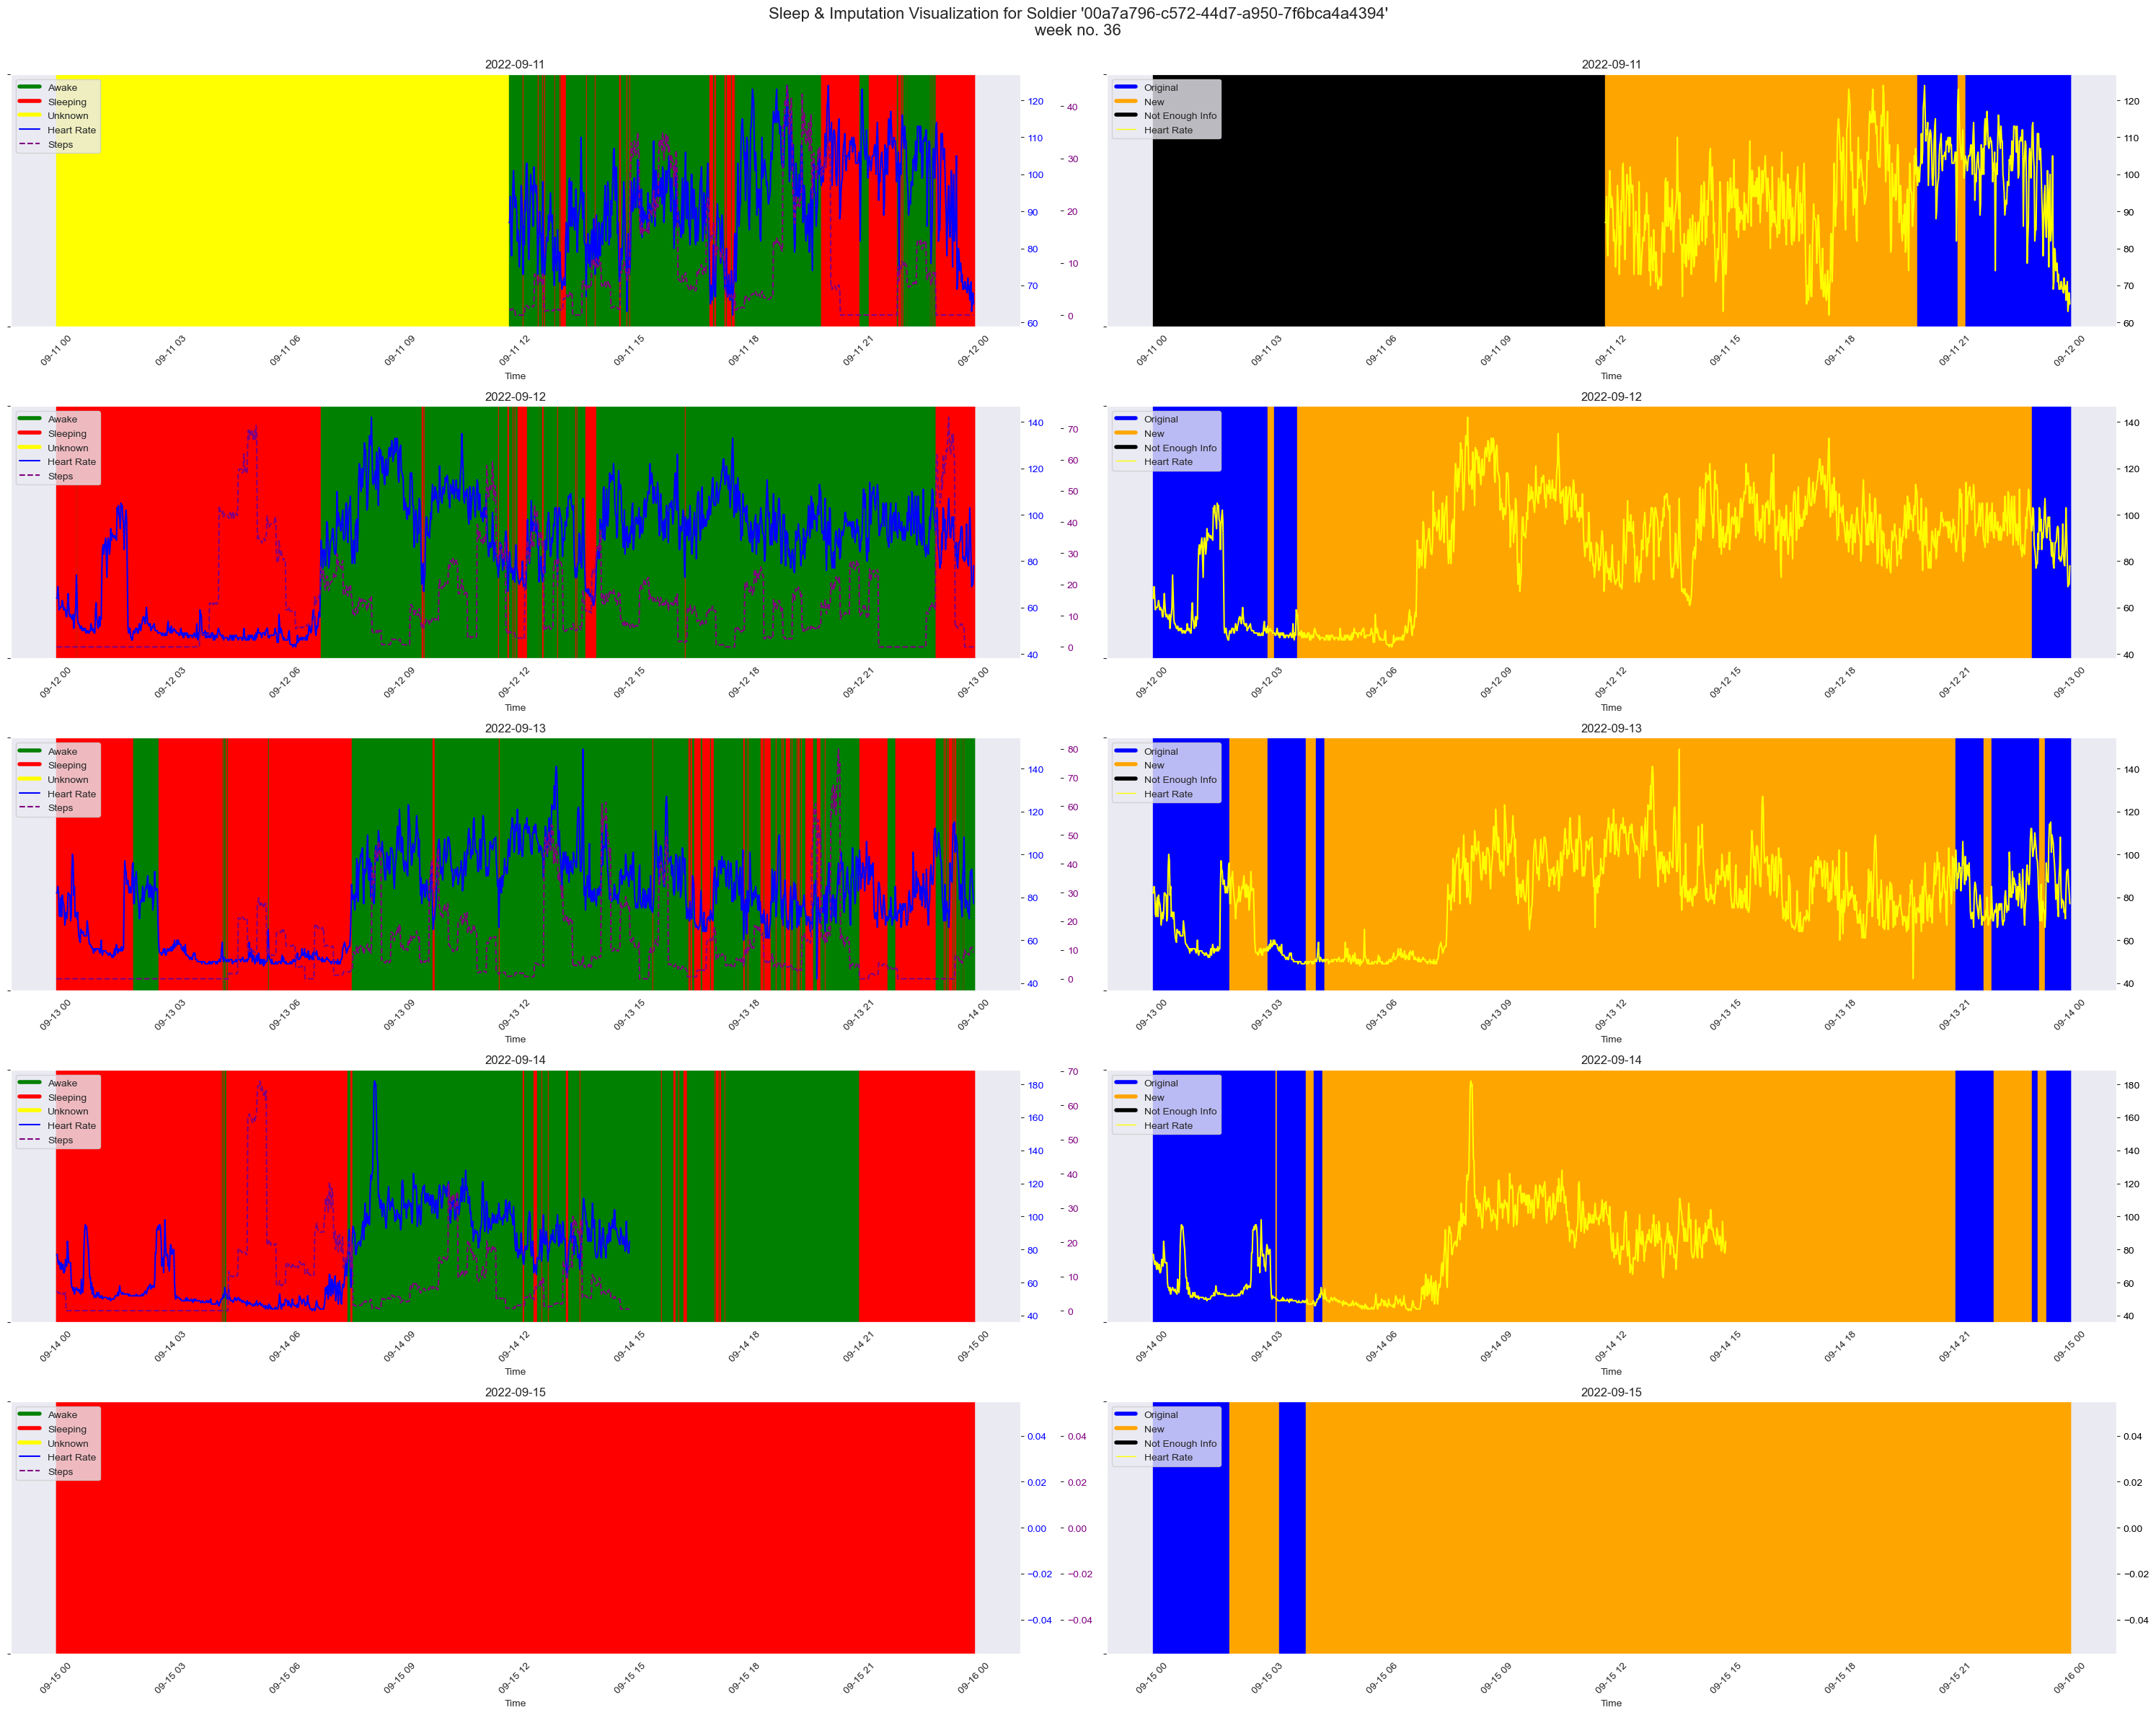

In [47]:
display_both('00a7a796-c572-44d7-a950-7f6bca4a4394', 36)

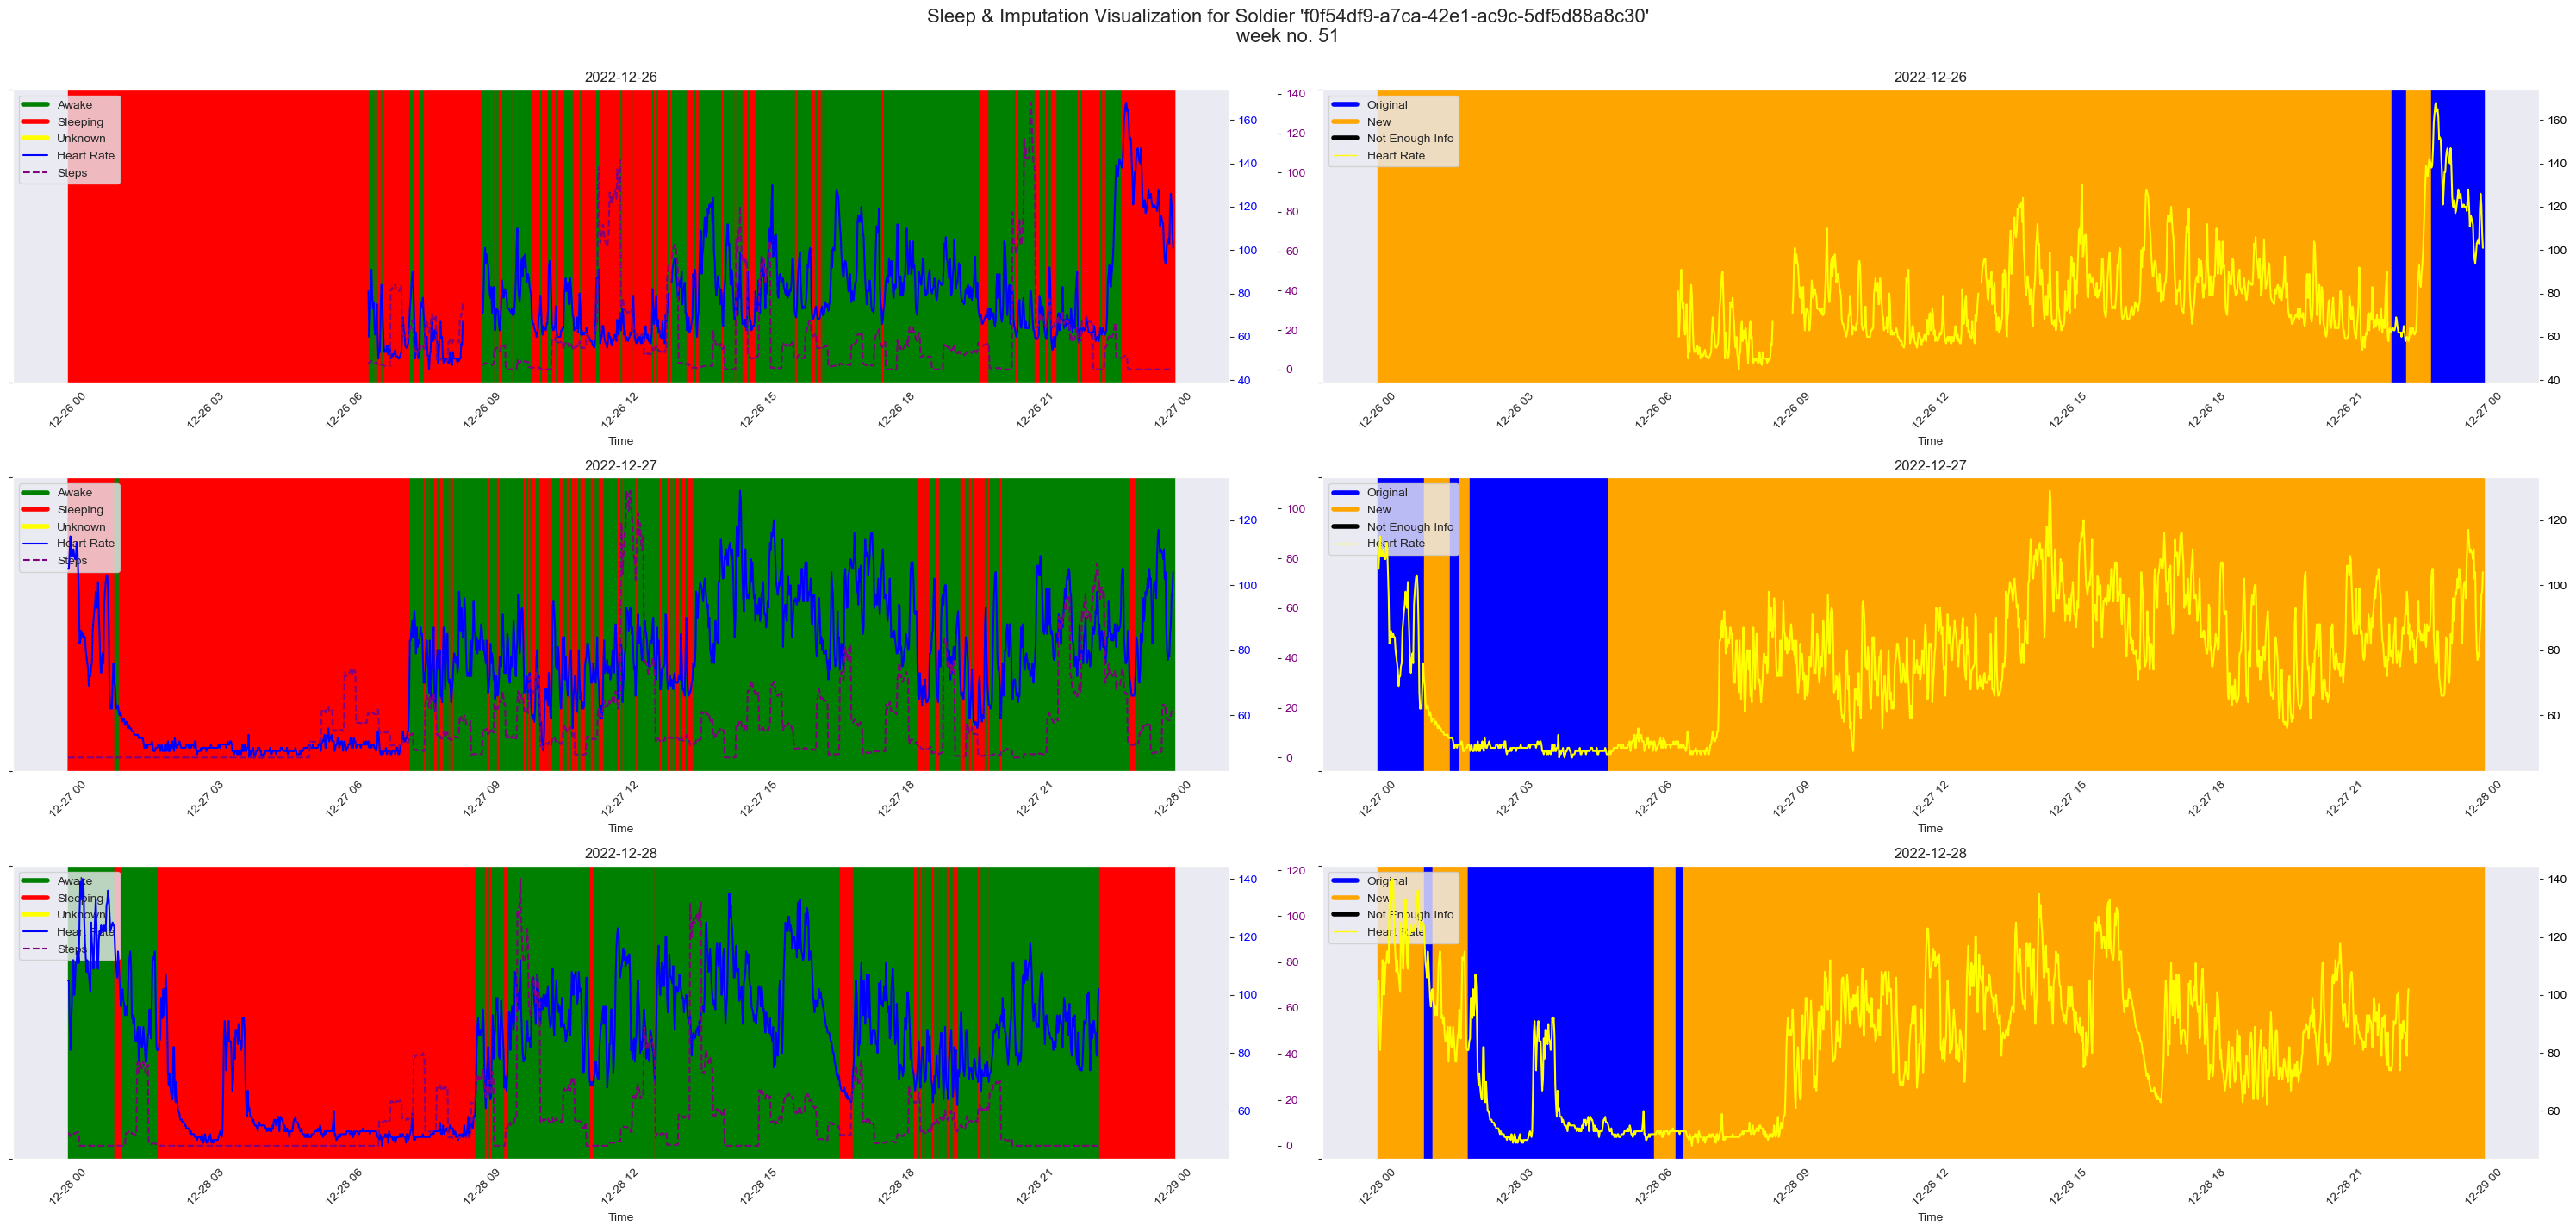

In [48]:
display_both('f0f54df9-a7ca-42e1-ac9c-5df5d88a8c30', 51)

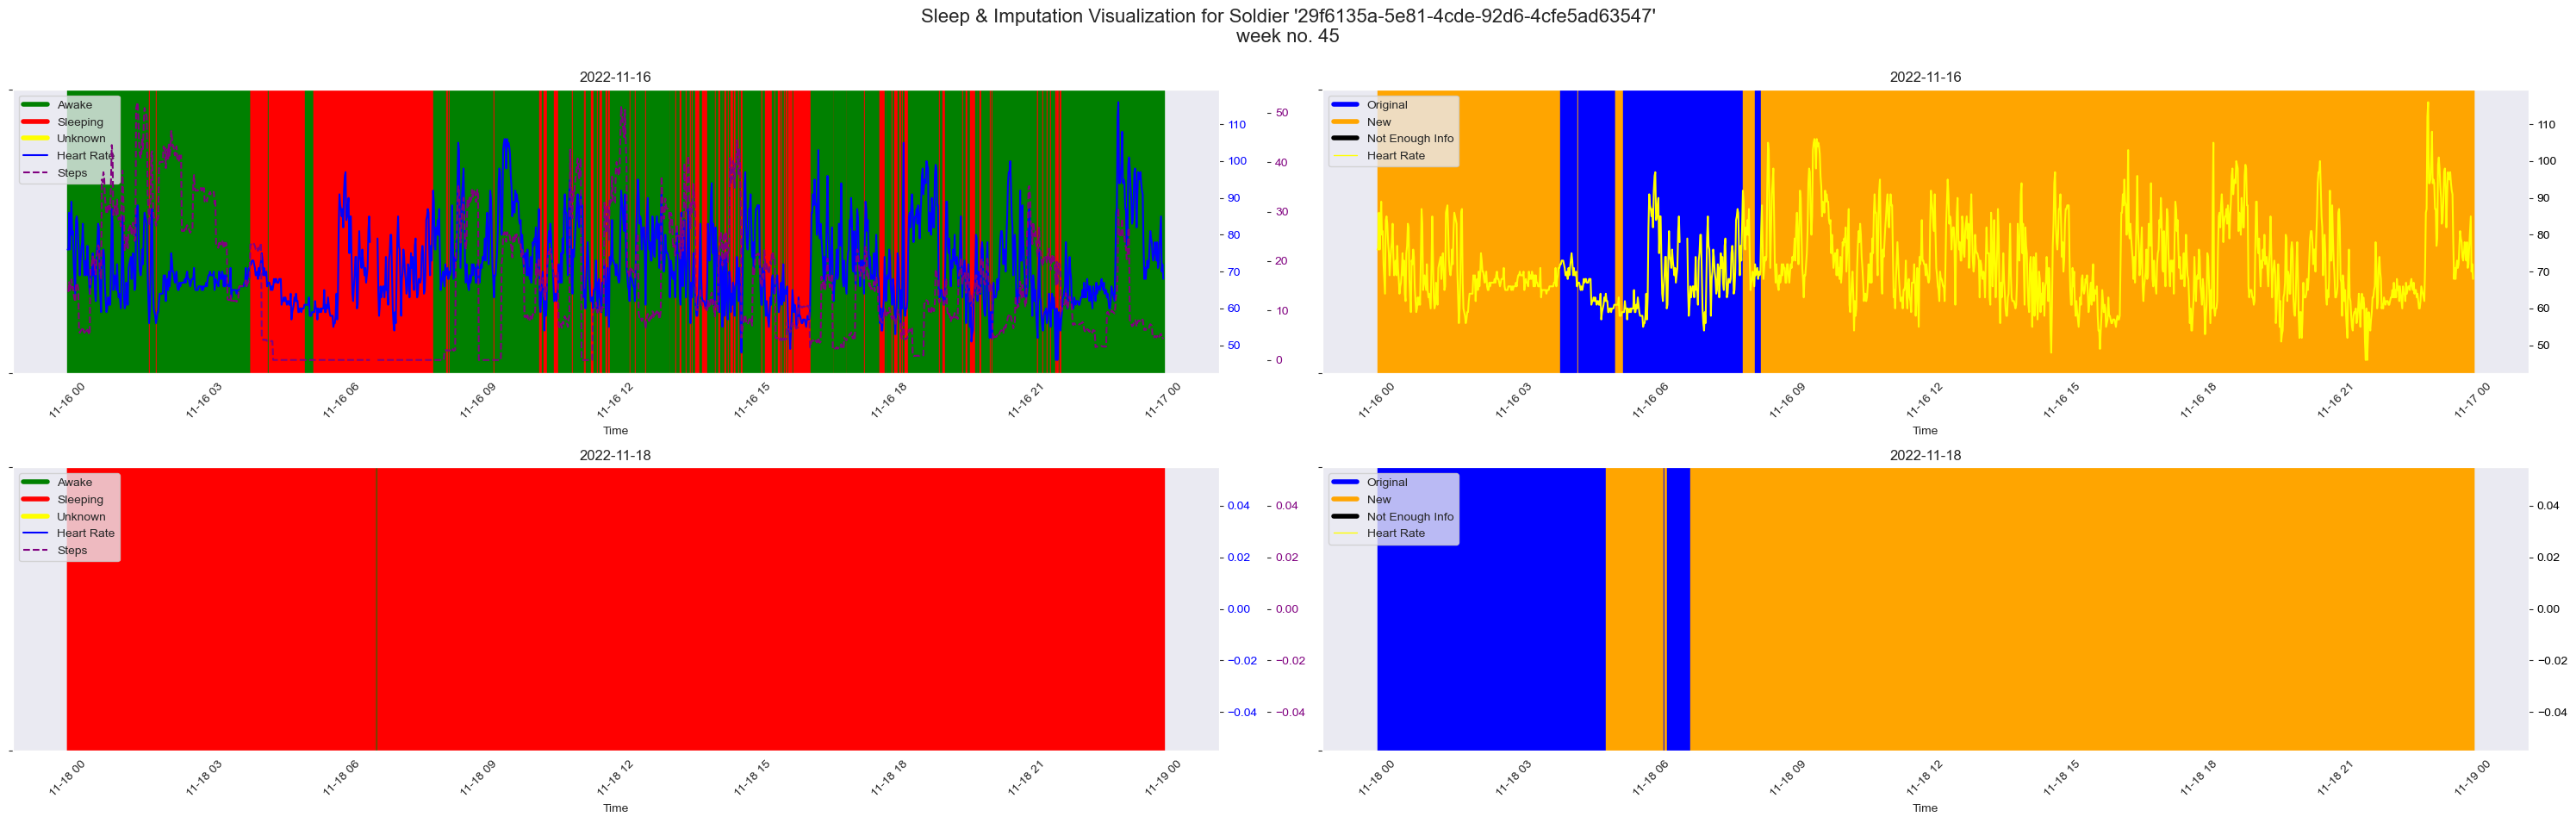

In [66]:
display_both('29f6135a-5e81-4cde-92d6-4cfe5ad63547', 45)

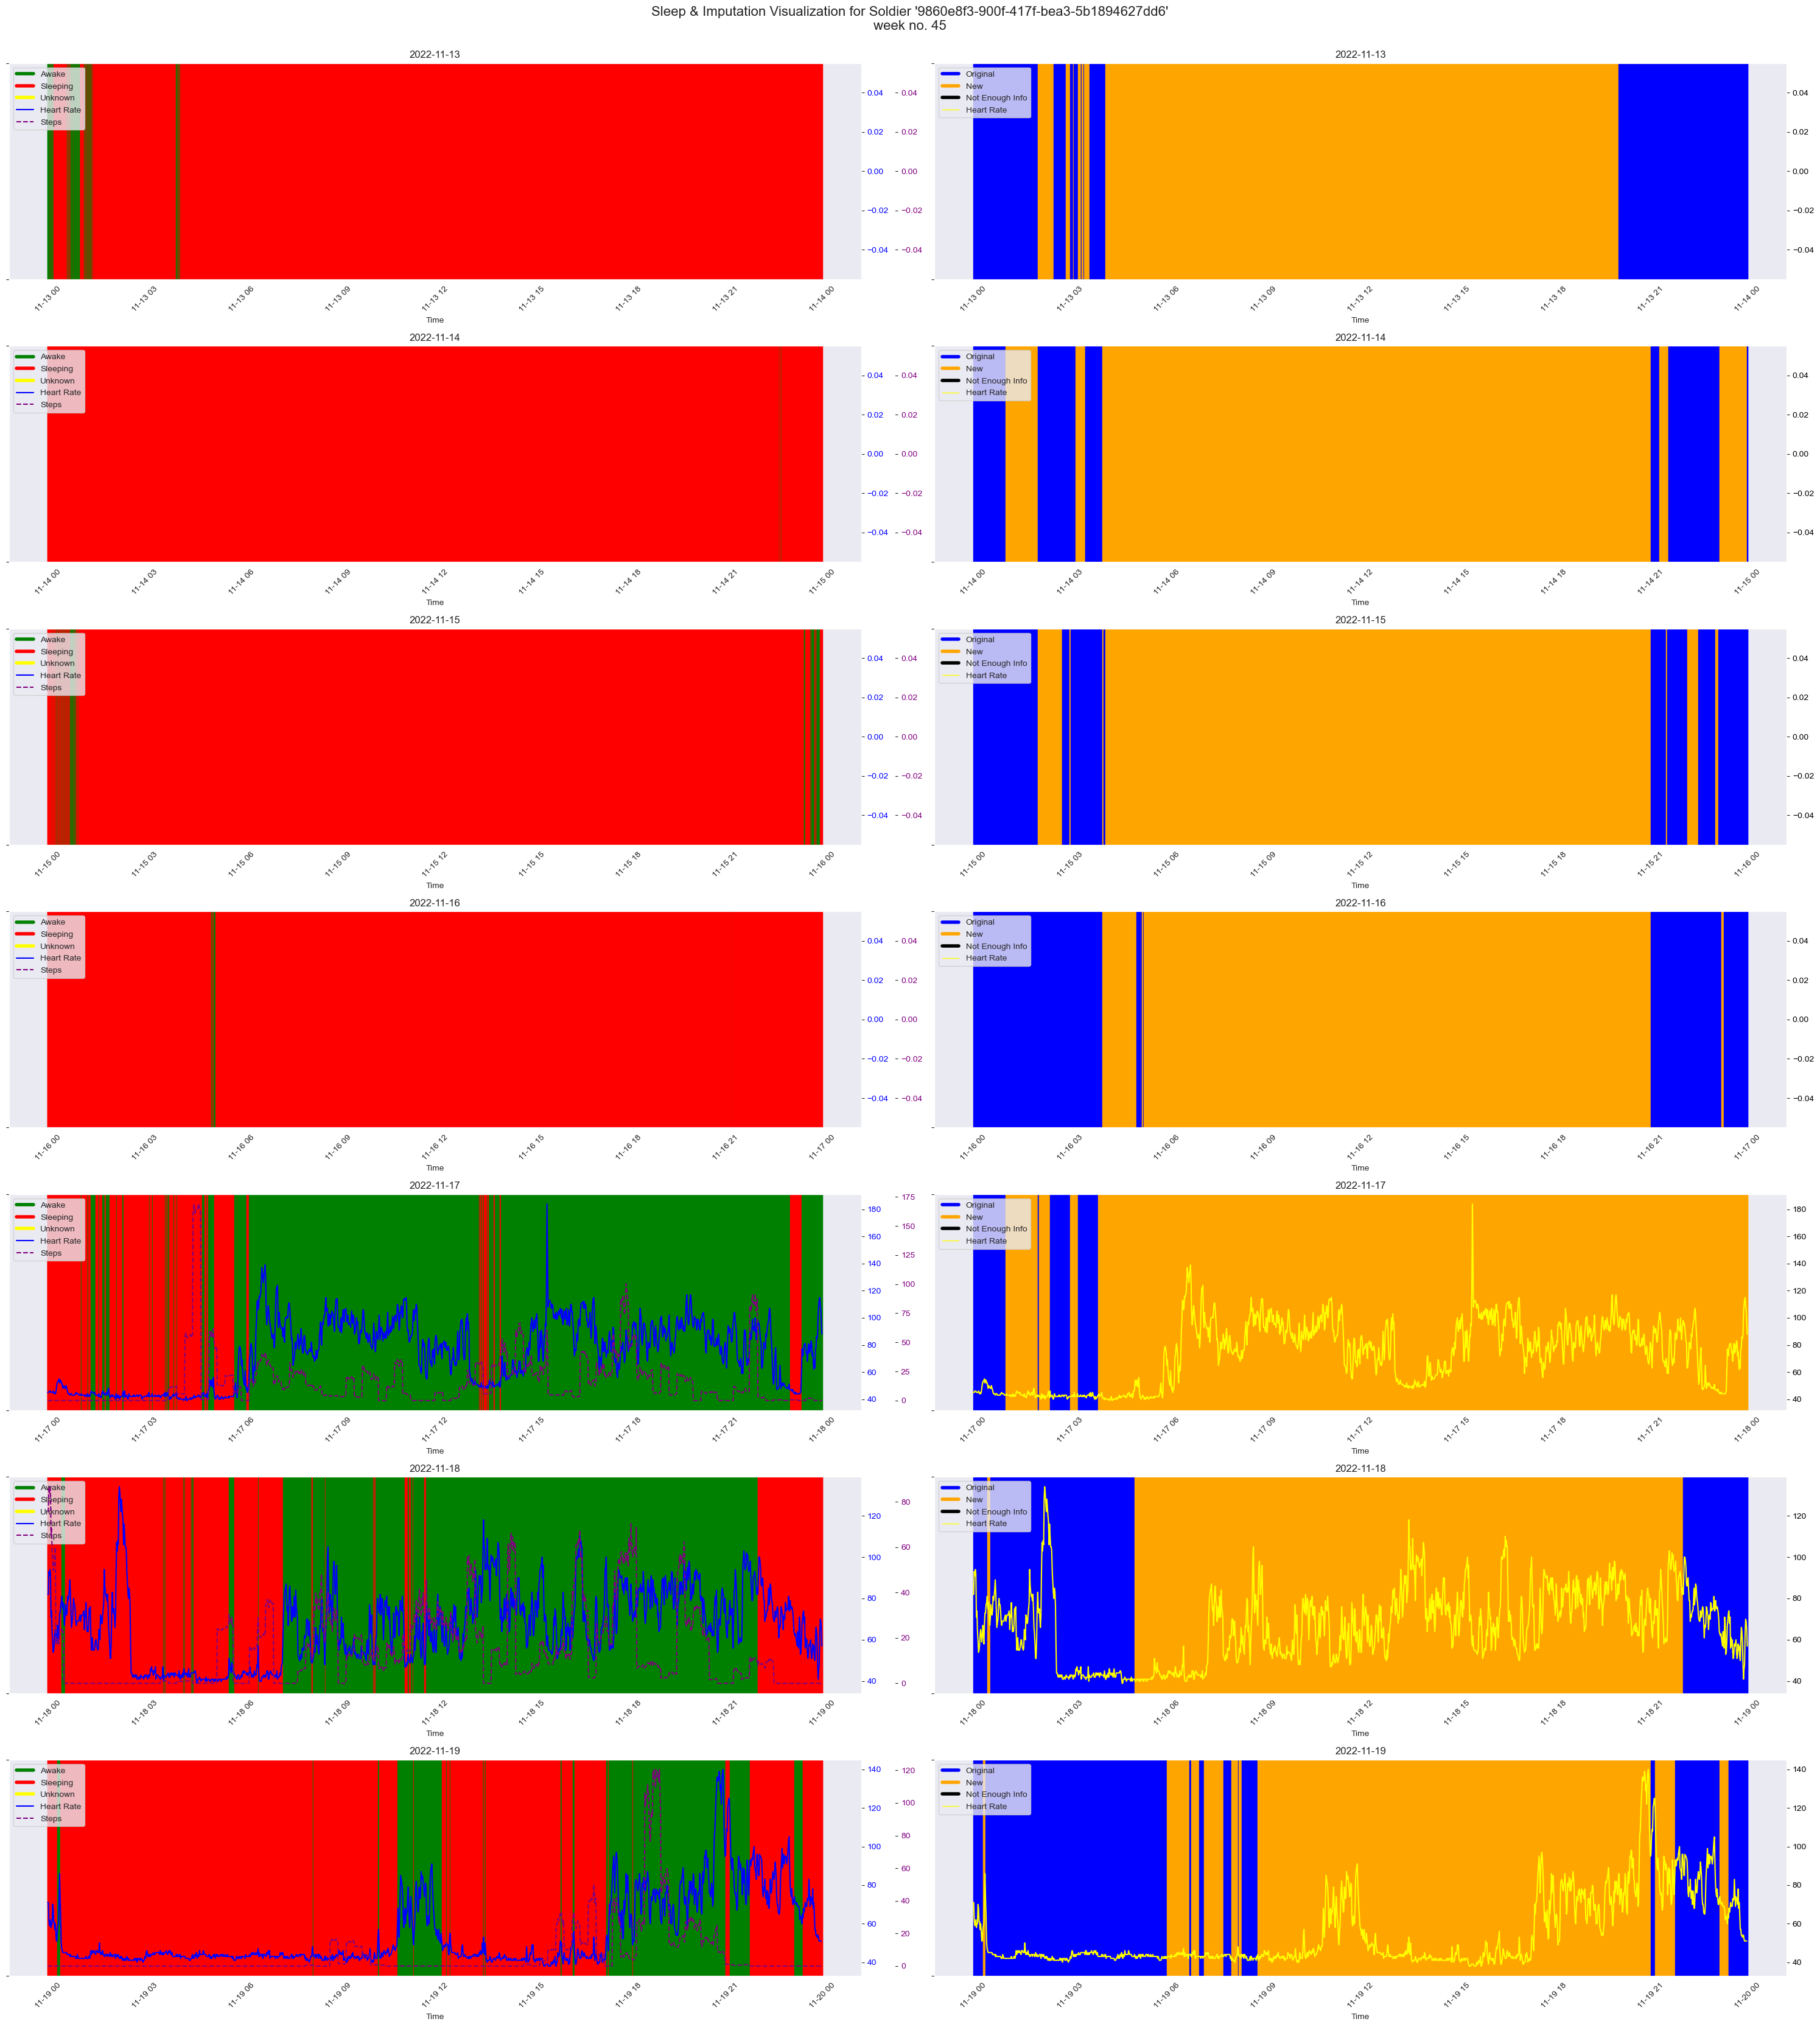

In [67]:
display_both('9860e8f3-900f-417f-bea3-5b1894627dd6', 45)

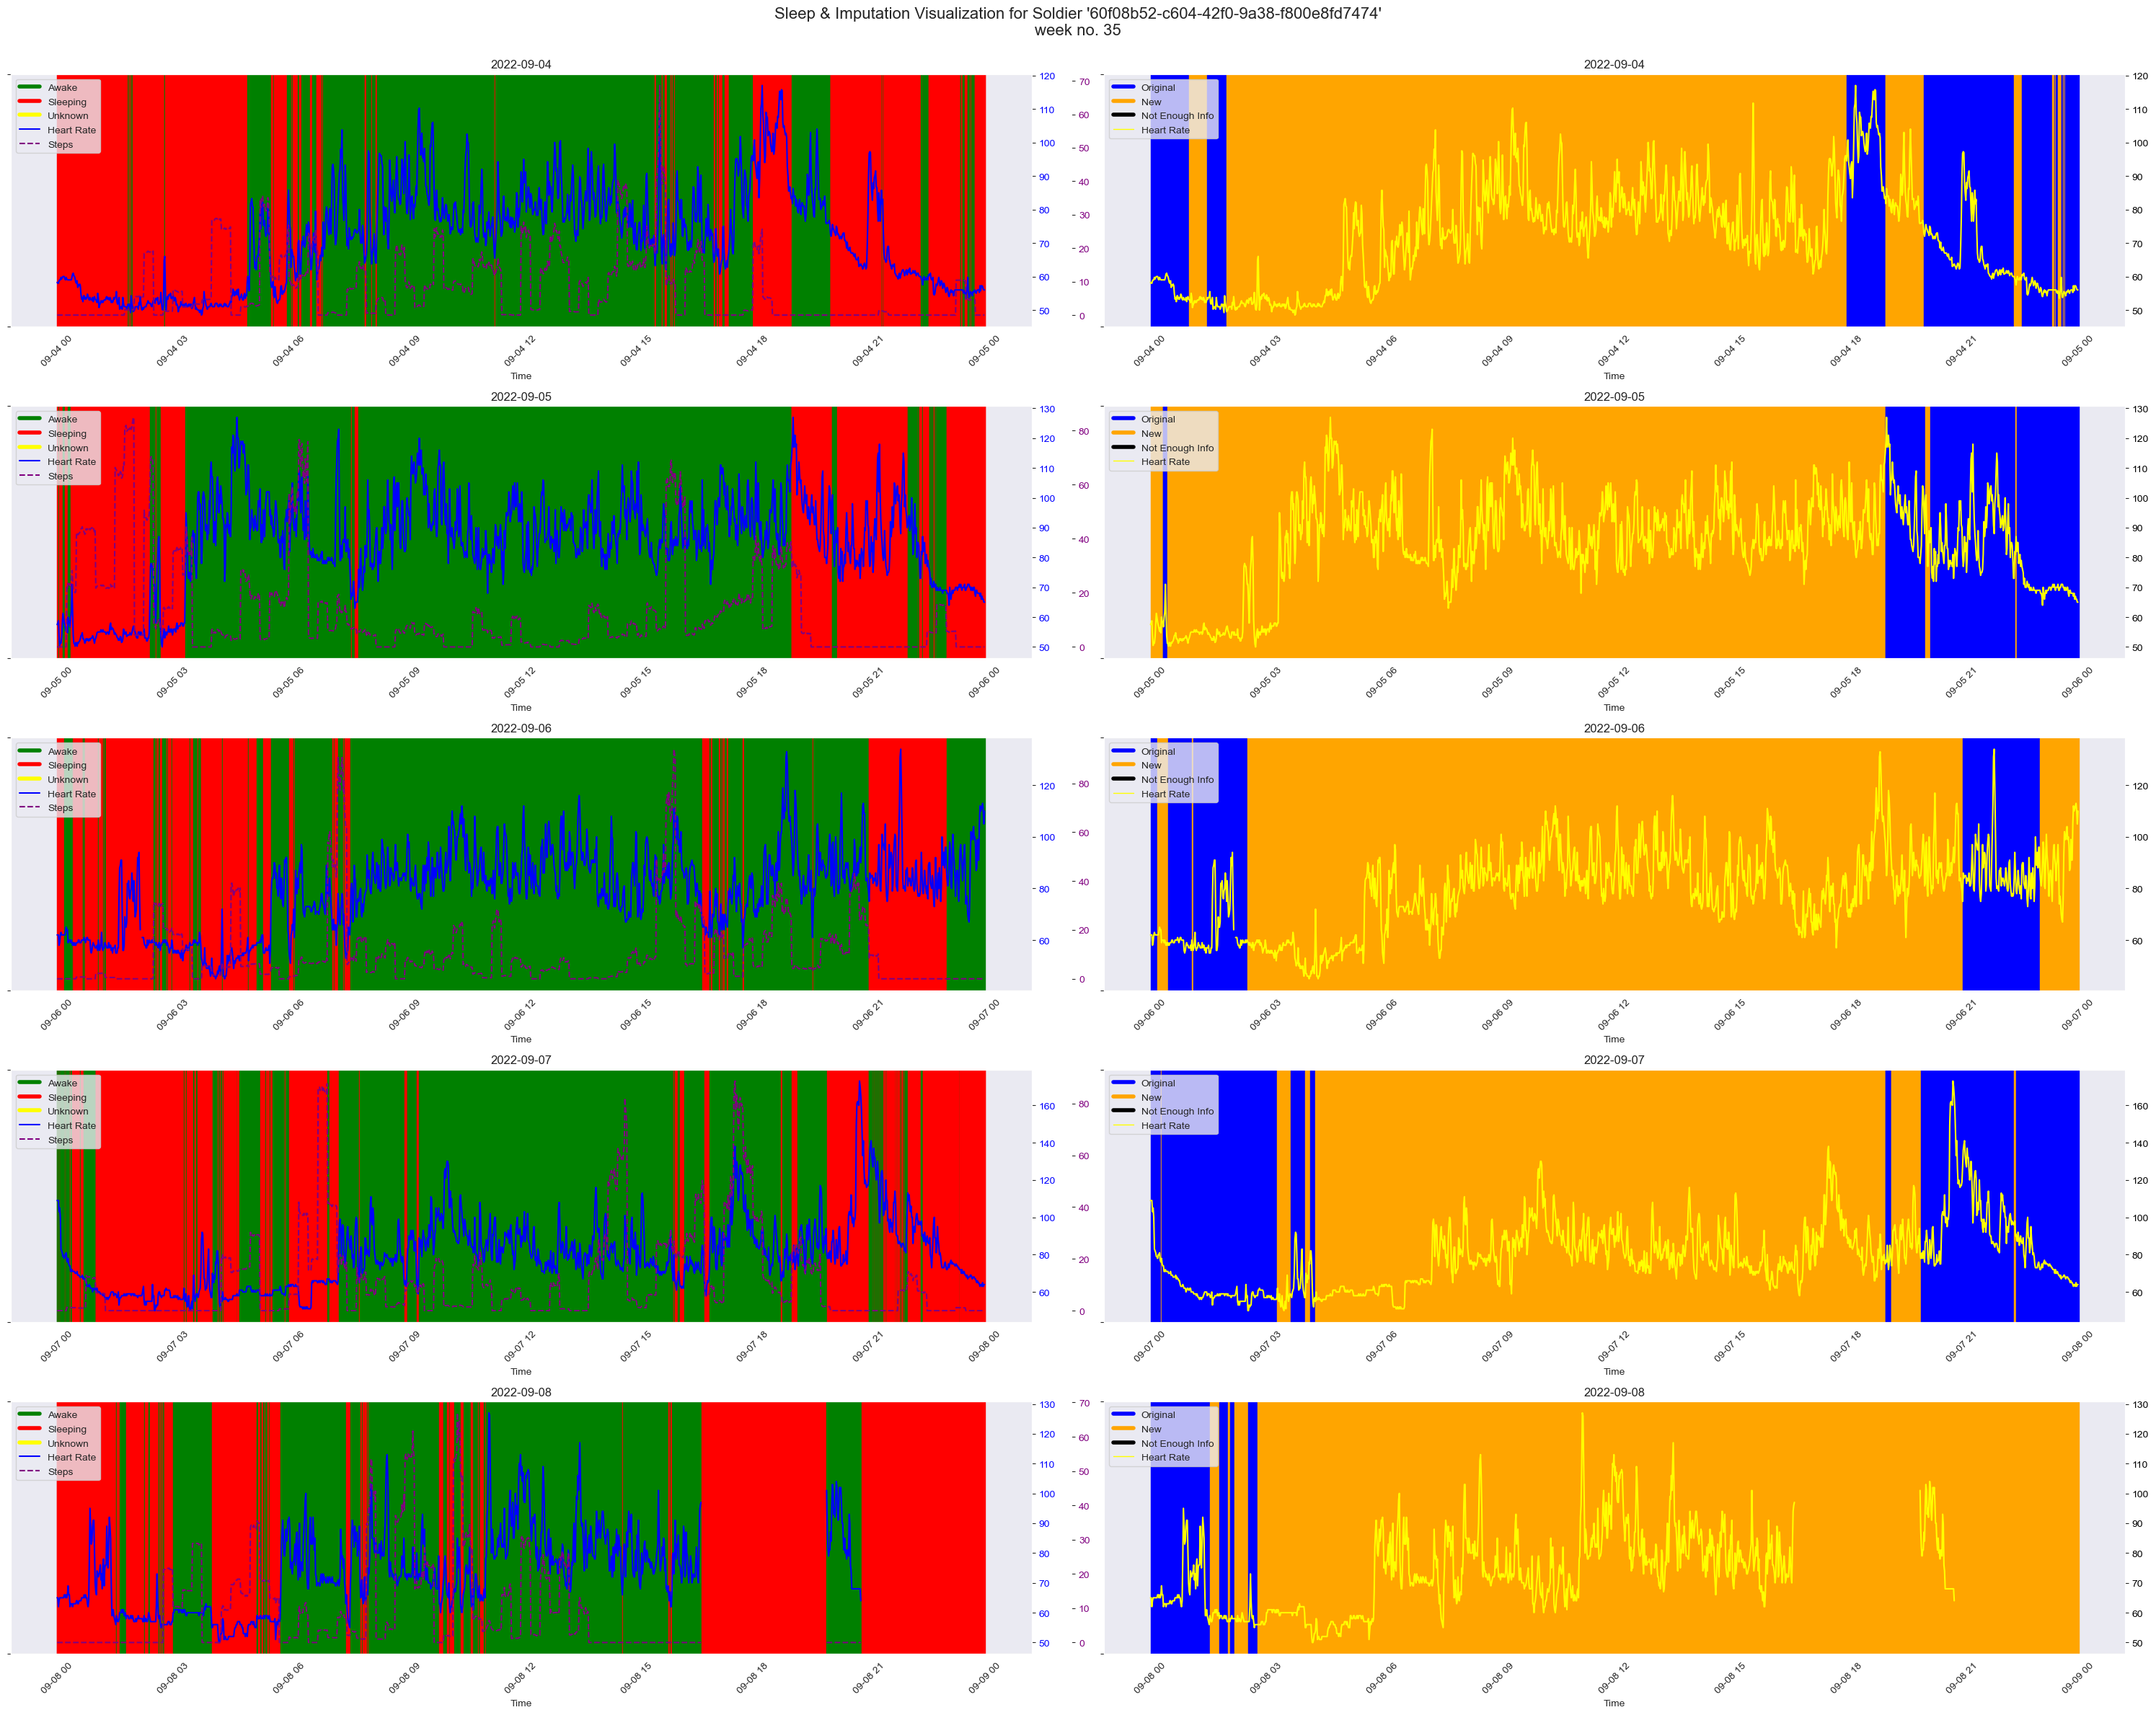

In [70]:
display_both('60f08b52-c604-42f0-9a38-f800e8fd7474', 35)